# Rotate and count player's in view

This notebook implements [Devin Pleuler's](https://x.com/devinpleuler) beautifully simple feature engineering to create a vector for each player, which describes a player's relation to the other players on the pitch. The original idea is from the [Fixed to Fluid: Frame-by-Frame Role Classification blog post](https://github.com/devinpleuler/research/blob/master/frame-by-frame-position.md)

In [1]:
import numpy as np
import pandas as pd
from mplsoccer import Pitch, arrowhead_marker, Sbopen
import matplotlib.pyplot as plt

Get a statsbomb 360 freeze frame

In [2]:
parser = Sbopen()
df_frame, df_visible = parser.frame(3788741)
df_teammate = df_frame[(df_frame.teammate)].copy()

# get random frame
event_id = 'f197a4df-75aa-4cd9-9769-11b09a1ac22c'
df = df_frame[df_frame['id'] == event_id].copy()
df_offence = df[df.teammate]
df_defence = df[~df.teammate]

Here we define a function that rotates each player around 360/16 degrees (16 times). For each direction the player faces, we count the number of players in their view.

This function rotates the other players around a player while fixing the player’s position - a neat trick to make the calculations easier. We also output a mask so we can plot how the function works.

In [3]:
def rotate_and_count(x, y, num_rotations=16):
    x = np.asarray(x)
    y = np.asarray(y)
    radians = np.linspace(0, 2 * np.pi, num_rotations, endpoint=False)

    X, _ = np.meshgrid(x, x)
    Y, _ = np.meshgrid(y, y)
    x_shifted = np.repeat(np.expand_dims(X - X.T, axis=0), num_rotations, axis=0)
    y_shifted = np.repeat(np.expand_dims(Y - Y.T, axis=0), num_rotations, axis=0)

    sin_rad = np.expand_dims(np.expand_dims(np.sin(radians), axis=1), axis=1)
    cos_rad = np.expand_dims(np.expand_dims(np.cos(radians), axis=1), axis=1)
    rotated_x = x_shifted * cos_rad - y_shifted * sin_rad
    mask = ((rotated_x + X.T) > X.T).T
    return mask.sum(axis=0), mask

Get the player counts and a mask for the chosen freeze frame. Here we see that the vectorized solution outputs the solution for all the players in the team (8) and all the rotation angles (16).

In [4]:
counts, mask = rotate_and_count(df_defence.x, df_defence.y)
counts.shape

(8, 16)

Next, we plot the results to show how the function works. It shows how the player rotates (arrow marker), the players counted in their field of view (green marker) or not counted in their field of view (grey marker).

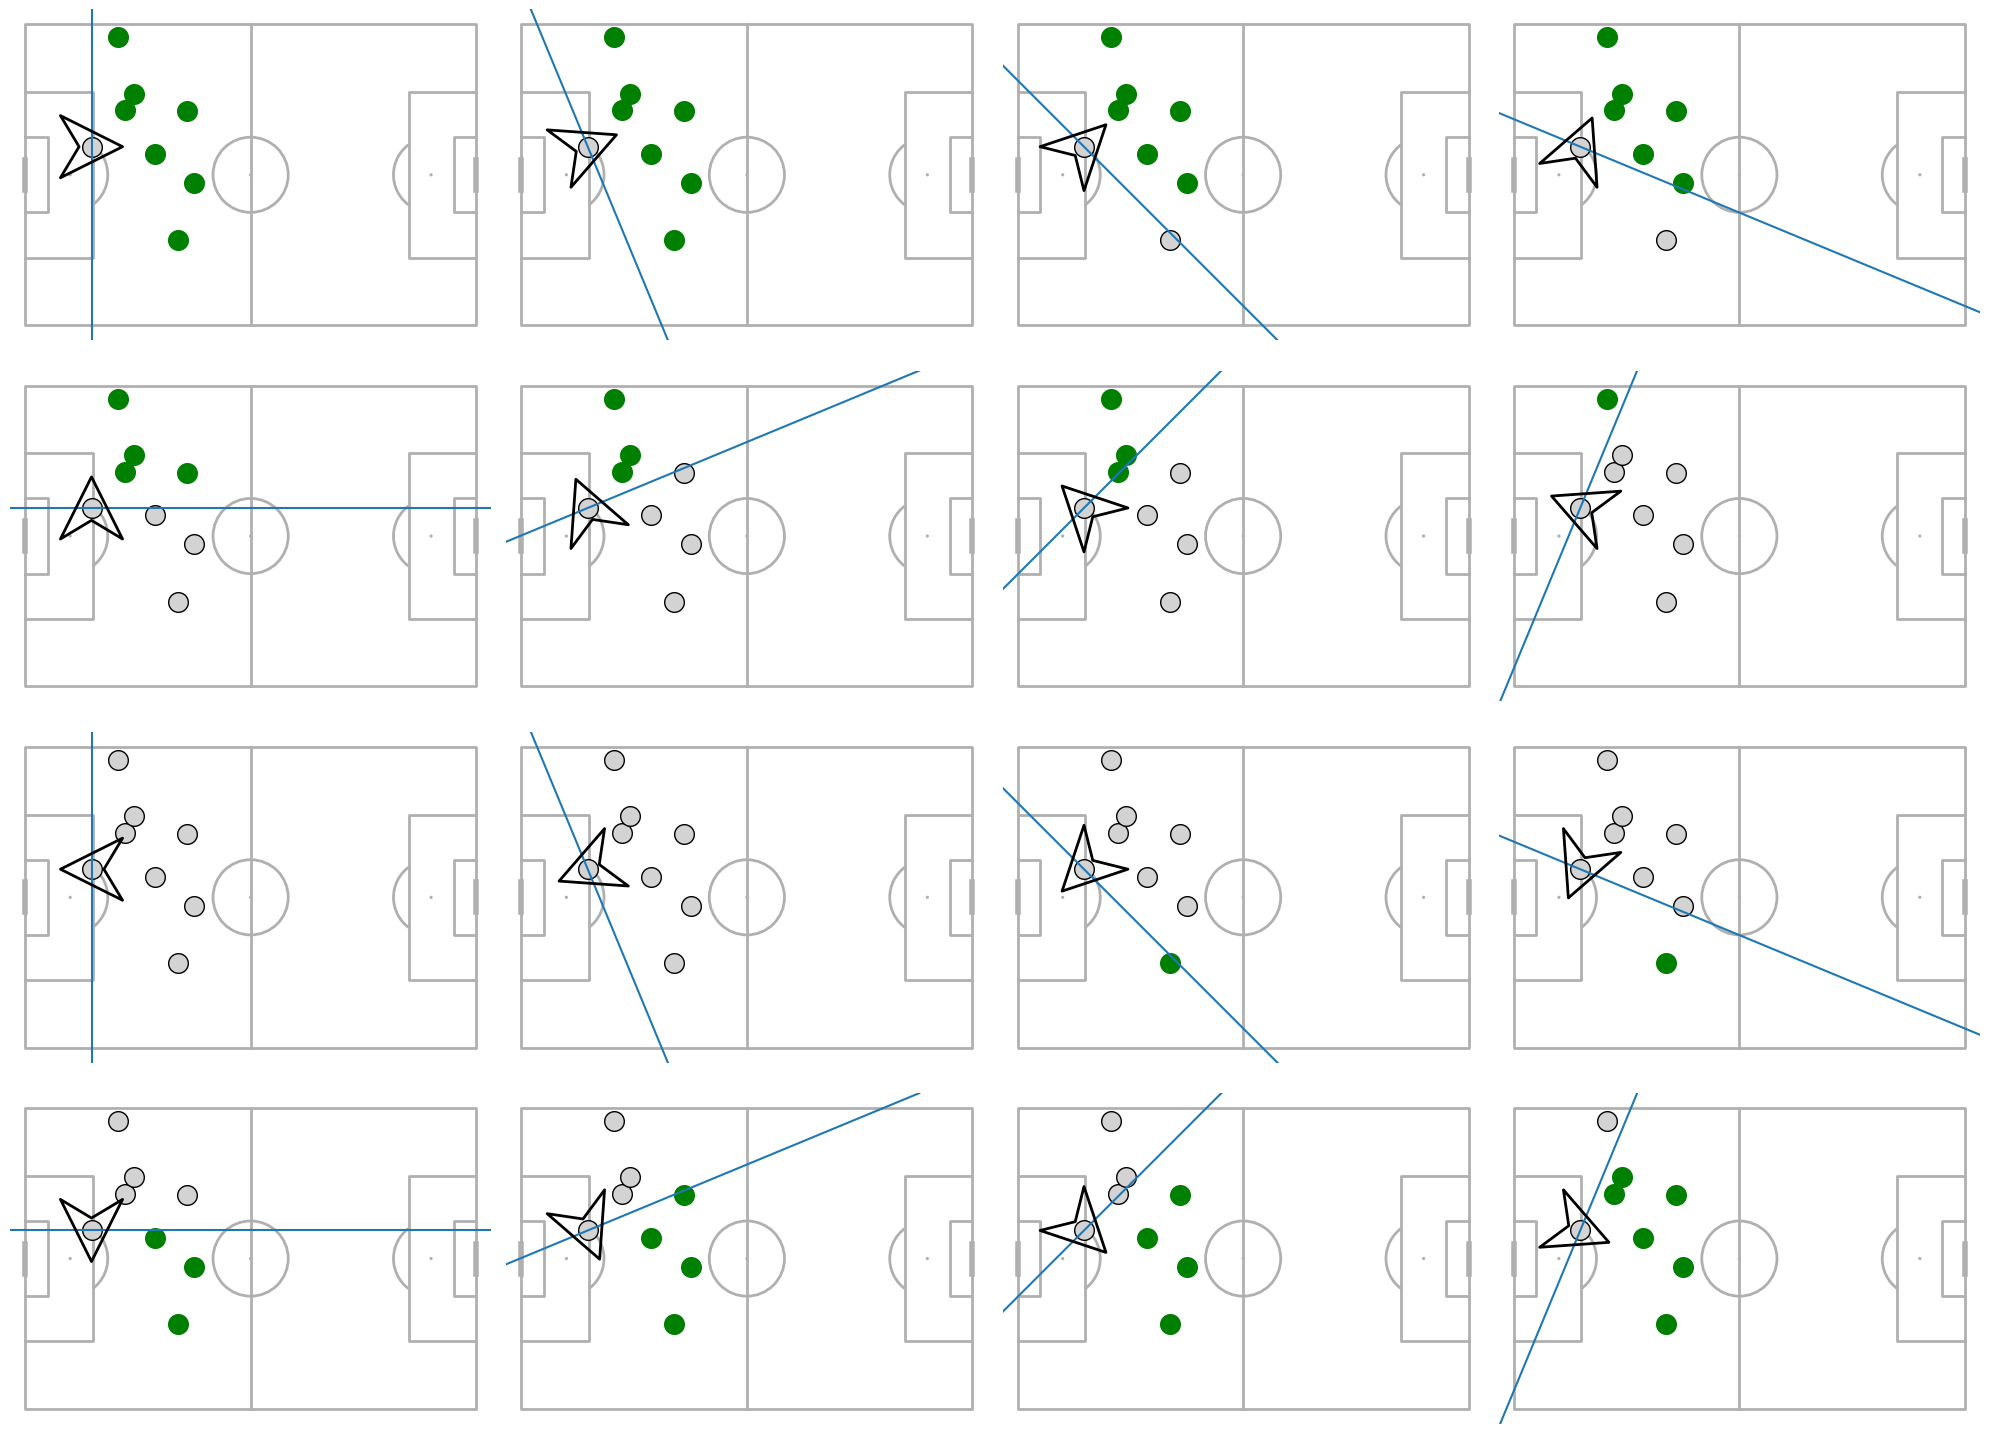

In [5]:
radians = np.linspace(2 * np.pi, 0, 16, endpoint=False)
slope = np.tan(radians - np.pi / 2)

p = Pitch()
fig, axs = p.draw(ncols=4, nrows=4, figsize=(20, 15))
player_no = 0
for i, ax in enumerate(axs.flat):
    p.scatter(df_defence[mask[:, player_no, i]].x, df_defence[mask[:, player_no, i]].y, ax=ax, s=200, color='green')
    p.scatter(df_defence[~mask[:, player_no, i]].x, df_defence[~mask[:, player_no, i]].y, ax=ax, s=200,
              color='#D3D3D3', ec='black')
    p.scatter(df_defence.iloc[player_no].x, df_defence.iloc[player_no].y, rotation_degrees=np.degrees(radians[i]),
              ax=ax, fc='None', ec='black', marker=arrowhead_marker, s=2000, lw=2, zorder=3)
    ax.axline((df_defence.iloc[player_no].x, df_defence.iloc[player_no].y), slope=slope[i])